#  Visualizing Adoption and Return Trends in Sonoma Animal Data
03/15/2024

#### Rafael L.S Reis, Dalia Cabrera Hurtado, Gabe Myers

## Introduction
The Sonoma Animal Shelter dataset, provided by the County of Sonoma Department of Health Services, comprises about 30,000 records detailing various attributes of animals admitted to the shelter. Each record includes species, breed, age, sex, and color, along with intake and outcome types to track the animals journey in the shelter. With over 4,000 animals entering the shelter annually, the dataset offers insights into adoption trends, shelter capacity, and animal welfare efforts. It gets updated regularly with the most recent being March 18, 2025.

This analysis seeks to answer two key questions: first, how does the number of days an animal spends in the shelter differ between those that are adopted and those that are returned to their owners; and second, is there an association between an animal's primary coat color—extracted from compound color entries—and its outcome or duration of shelter stay.

note: This is tentative and we will likely hone down our scope of questionings(likely to colors)

data downloaded from:
https://raw.githubusercontent.com/grbruns/cst383/master/sonoma-shelter-15-october-2024.csv

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Initial Data Exploration

In [36]:
df = pd.read_csv('https://raw.githubusercontent.com/grbruns/cst383/master/sonoma-shelter-17-march-2025.csv')

## Data preprocessing

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29012 entries, 0 to 29011
Data columns (total 24 columns):
Name                    21354 non-null object
Type                    29012 non-null object
Breed                   29012 non-null object
Color                   29012 non-null object
Sex                     29012 non-null object
Size                    28976 non-null object
Date Of Birth           21897 non-null object
Impound Number          29012 non-null object
Kennel Number           29004 non-null object
Animal ID               29012 non-null object
Intake Date             29012 non-null object
Outcome Date            28746 non-null object
Days in Shelter         29012 non-null int64
Intake Type             29012 non-null object
Intake Subtype          29012 non-null object
Outcome Type            28740 non-null object
Outcome Subtype         28405 non-null object
Intake Condition        29012 non-null object
Outcome Condition       28383 non-null object
Intake Jurisdictio

In [41]:
df.sample(10)

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,...,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count
27982,OCEAN,DOG,BOXER,WHITE,Female,MED,NaN,K19-034910,TRUCK,A395179,...,FIELD,RETURN TO OWNER,FLD_MCHIP,UNKNOWN,HEALTHY,SANTA ROSA,SANTA ROSA,95401.0,"95401(38.44366, -122.7246163)",1
21423,29102,CAT,DOMESTIC SH,ORG TABBY,Male,KITTN,02/05/2023,K23-044302,HSSC,A416541,...,PHONE,TRANSFER,HSSC,UNKNOWN,PENDING,SANTA ROSA,COUNTY,95407.0,"95407(38.4127094, -122.7412153)",1
4442,*KARI,CAT,DOMESTIC SH,TORTIE,Spayed,KITTN,06/01/2018,K18-029389,LOBBY,A375217,...,OVER THE COUNTER,ADOPTION,SPEC EVENT,TREATABLE/REHAB,HEALTHY,SANTA ROSA,COUNTY,95472.0,"95472(38.4007555, -122.8277055)",1
8685,BILLY,DOG,PIT BULL,WHITE/BR BRINDLE,Neutered,LARGE,NaN,K18-029143,DS92,A396164,...,FLD_ARREST,RETURN TO OWNER,OVER THE COUNTER_ARREST,HEALTHY,HEALTHY,SANTA ROSA,SANTA ROSA,95401.0,"95401(38.44366, -122.7246163)",1
8578,WILLOW,DOG,LABRADOR RETR/GOLDEN RETR,GOLD,Spayed,LARGE,12/30/2015,K23-043920,DS58,A341729,...,OVER THE COUNTER,RETURN TO OWNER,OVER THE COUNTER_MCHIP,UNKNOWN,PENDING,COUNTY,COUNTY,95472.0,"95472(38.4007555, -122.8277055)",1
3422,BRUNO,DOG,LABRADOR RETR,BLACK,Neutered,MED,NaN,K16-021191,TRUCK,A343787,...,FIELD,RETURN TO OWNER,FLD_MCHIP,HEALTHY,HEALTHY,COUNTY,COUNTY,95476.0,"95476(38.288405, -122.464525)",1
10740,EMILY,DOG,ITAL GREYHOUND,BLACK/WHITE,Female,SMALL,NaN,K14-011893,TRUCK,A314423,...,FLD_ARREST,RETURN TO OWNER,FLD_PRVS,HEALTHY,HEALTHY,COUNTY,*ROHNERT PARK,NaN,NaN,1
3748,NaN,DOG,GERM SHEPHERD,BLACK/TAN,Female,LARGE,NaN,K19-032272,DQ113,A387165,...,FLD_STRAY,EUTHANIZE,AGGRESSIVE,UNKNOWN,HEALTHY,SANTA ROSA,SANTA ROSA,95407.0,"95407(38.4127094, -122.7412153)",1
11462,CHUY,DOG,PIT BULL,TAN/GRAY,Neutered,LARGE,05/13/2016,K22-040416,DS76,A339772,...,FIELD,RETURN TO OWNER,OVER THE COUNTER_WEB,UNKNOWN,PENDING,SANTA ROSA,SANTA ROSA,95403.0,"95403(38.4716444, -122.7398255)",1
24827,*PATRICK,CAT,DOMESTIC SH,BRN TABBY,Neutered,KITTN,07/28/2020,K20-036880,WESTFARM,A400655,...,OVER THE COUNTER,ADOPTION,WESTFARM,UNKNOWN,PENDING,COUNTY,COUNTY,95403.0,"95403(38.4716444, -122.7398255)",1


Among dogs returned to their owners, which coat colors are most frequently associated with being lost or having escaped? To try explore this, we can create a simplified color category column to analyze color hues effectively.

Below are the functions to help create a new column to get the color shade of the animals

In [47]:
# Function to get primary color from a color string
def get_primary_color(color):
    if pd.isnull(color):
        return 'unknown'
    return color.split('/')[0].strip().lower()

# Helper function to check if primary color is in a given list, maybe not necessary but cleaner?
def primary_color_in_list(primary_color, shades_list):
    return any(shade in primary_color for shade in shades_list)

# Function to categorize color into Light, Medium, Dark, or Other shades
def categorize_shade(color):
    if pd.isna(color):
        return 'Unknown'

    primary_color = get_primary_color(color)
    # mappings, might play around with these more...
    dark_shades = ['black', 'brown', 'brindle', 'blue', 'gray', 'chocolate', 'seal']
    medium_shades = ['tan', 'red', 'gold', 'fawn', 'sable', 'yellow', 'orange']
    light_shades = ['white', 'cream', 'buff']

    if primary_color_in_list(primary_color, dark_shades):
        return 'Dark'
    elif primary_color_in_list(primary_color, medium_shades):
        return 'Medium'
    elif primary_color_in_list(primary_color, light_shades):
        return 'Light'
    else:
        return 'Other'



Applying filter to create column

In [50]:
dogs_returned = df[
    (df['Type'] == 'DOG') &
    (df['Outcome Type'].str.upper() == 'RETURN TO OWNER')
].copy()

# Create 'Primary Color' column
dogs_returned['Primary Color'] = dogs_returned['Color'].apply(get_primary_color)

# Create 'Primary Shade' column correctly
dogs_returned['Primary Shade'] = dogs_returned['Primary Color'].apply(categorize_shade)

# just sampling to check if things look about right
print(dogs_returned[['Name', 'Color', 'Primary Color', 'Primary Shade']].head(10))

      Name             Color Primary Color Primary Shade
5    FAUNA              FAWN          fawn        Medium
9   TIMBER       BLACK/WHITE         black          Dark
12    RUPI       BLACK/WHITE         black          Dark
15   MONEY         TAN/WHITE           tan        Medium
18    GAIA             BLACK         black          Dark
36   PINTO  BR BRINDLE/WHITE    br brindle          Dark
39   BELLA               TAN           tan        Medium
40   ROCKY       WHITE/BLACK         white         Light
43   BUDDY             WHITE         white         Light
45  MUNECA             WHITE         white         Light


## Data exploration and visualization

Exploring data from primary color column

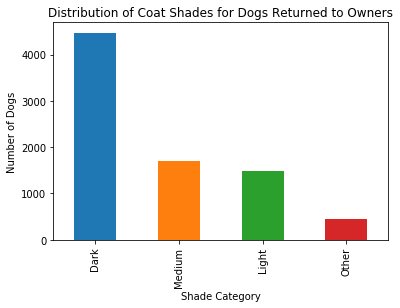

In [54]:
# Plot the shade distribution
shade_counts = dogs_returned['Primary Shade'].value_counts()
shade_counts.plot(kind='bar')

plt.title('Distribution of Coat Shades for Dogs Returned to Owners')
plt.xlabel('Shade Category')
plt.ylabel('Number of Dogs')
plt.show()

Data above looks good(at least we can see the relative primary colors), but doesn't give us the full picture, maybe there's just more black dogs. Let's explore some more. Out of all dogs of a given shade, what's the proportion successfully returned to their owner?

## Conclusions

For now we still need to explore more and improve the notebook. As it stands it's pretty messy but we just wanted to explore as much as we could first and see if we found anything of interest or significance rather than caring too much about form. As we hone down on our areas of interest we will make the data look better and have better descriptions and organization. Lastly exploring the effects of color might be more interesting(given our exploration) so we might pivot to focus more on that.